#Import Library

In [ ]:
!pip install tensorflowjs
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input
from tensorflow.keras.preprocessing import image
import os
import numpy as np
import pathlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from google.colab import files

!pip install opendatasets
import opendatasets as op

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 84 kB 888 kB/s 
     |████████████████████████████████| 588.3 MB 20 kB/s 
     |████████████████████████████████| 189 kB 12.3 MB/s 
     |████████████████████████████████| 16.2 MB 552 kB/s 
     |████████████████████████████████| 40 kB 2.3 MB/s 
     |████████████████████████████████| 154 kB 9.8 MB/s 
     |████████████████████████████████| 8.3 MB 43.2 MB/s 
     |████████████████████████████████| 237 kB 62.6 MB/s 
     |████████████████████████████████| 51 kB 7.5 MB/s 
     |████████████████████████████████| 1.7 MB 64.1 MB/s 
     |████████████████████████████████| 439 kB 63.5 MB/s 
     |████████████████████████████████| 6.0 MB 39.0 MB/s 
     |████████████████████████████████| 85 kB 5.0 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.9.0
    Uninstalling tensorflow-estimator-2.9.0:
      

##download dataset

In [ ]:
op.download("https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia/")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: jrizky
Your Kaggle Key: ··········


100%|██████████| 2.29G/2.29G [00:16<00:00, 150MB/s]


#Explore data / Data understanding

In [ ]:
base_dir = 'chest-xray-pneumonia/chest_xray/train'
data = os.path.join(base_dir)
os.listdir(data)

['NORMAL', 'PNEUMONIA']

#Data pre- processing

In [ ]:
training_generator = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 30,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest',
    validation_split = 0.2
)

In [ ]:
pneumonia = tf.keras.preprocessing.image_dataset_from_directory(
  base_dir,
  image_size=(150, 150)
  )

Found 5216 files belonging to 2 classes.


In [ ]:
class_names = pneumonia.class_names
print(class_names)

['NORMAL', 'PNEUMONIA']


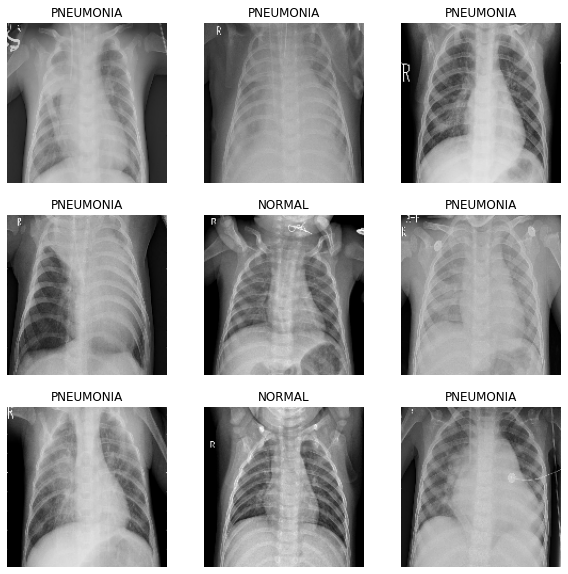

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in pneumonia.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
train_gen = training_generator.flow_from_directory(
    data,
    target_size = (150,150),
    batch_size=64,
    classes=['NORMAL', 'PNEUMONIA'],
    class_mode = 'categorical',
    subset = 'training'
)

valid_gen = training_generator.flow_from_directory(
    data,
    target_size = (150,150),
    batch_size=64,
    classes=['NORMAL', 'PNEUMONIA'],
    class_mode = 'categorical',
    subset='validation'
    )

Found 4173 images belonging to 2 classes.
Found 1043 images belonging to 2 classes.


#Modeling

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 72, 72, 32)        9248      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 17, 17, 64)      

In [ ]:
model.compile(loss = 'categorical_crossentropy',
              optimizer=tf.optimizers.Adam(),
              metrics=['accuracy'])

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.9 and logs.get('val_accuracy')>0.9): 
      print("\nAkurasi telah mencapai >90%")
      self.model.stop_training=True
callbacks = myCallback()

#Training

In [ ]:
history = model.fit(
    train_gen,
    validation_data=valid_gen,
    steps_per_epoch=10,                                                     
    epochs=50,                                    
    verbose=2,
    callbacks=[callbacks],
    shuffle = True
    )

Epoch 1/50
10/10 - 36s - loss: 0.7466 - accuracy: 0.6625 - val_loss: 0.5712 - val_accuracy: 0.7430 - 36s/epoch - 4s/step
Epoch 2/50
10/10 - 25s - loss: 0.5462 - accuracy: 0.7750 - val_loss: 0.5821 - val_accuracy: 0.7430 - 25s/epoch - 2s/step
Epoch 3/50
10/10 - 24s - loss: 0.5798 - accuracy: 0.7422 - val_loss: 0.5449 - val_accuracy: 0.7430 - 24s/epoch - 2s/step
Epoch 4/50
10/10 - 25s - loss: 0.5496 - accuracy: 0.7334 - val_loss: 0.4994 - val_accuracy: 0.7430 - 25s/epoch - 2s/step
Epoch 5/50
10/10 - 23s - loss: 0.4888 - accuracy: 0.7734 - val_loss: 0.4636 - val_accuracy: 0.7699 - 23s/epoch - 2s/step
Epoch 6/50
10/10 - 23s - loss: 0.4034 - accuracy: 0.8125 - val_loss: 0.3579 - val_accuracy: 0.8255 - 23s/epoch - 2s/step
Epoch 7/50
10/10 - 24s - loss: 0.3232 - accuracy: 0.8469 - val_loss: 0.3478 - val_accuracy: 0.8351 - 24s/epoch - 2s/step
Epoch 8/50
10/10 - 24s - loss: 0.2508 - accuracy: 0.8813 - val_loss: 0.3209 - val_accuracy: 0.8648 - 24s/epoch - 2s/step
Epoch 9/50
10/10 - 25s - loss: 0

#Evaluation

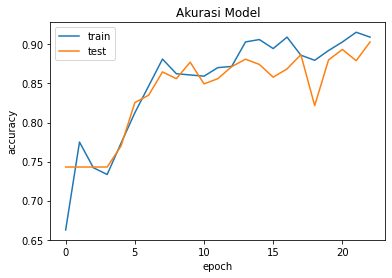

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Akurasi Model')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

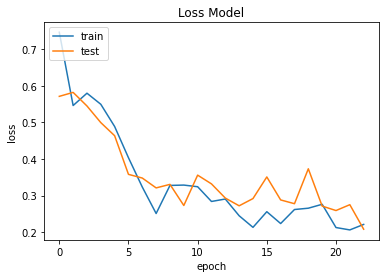

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Saving IM-0119-0001.jpeg to IM-0119-0001 (1).jpeg
1/1 [==============================] - 0s 21ms/step
IM-0119-0001.jpeg
Normal


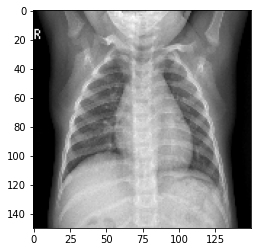

In [ ]:
import numpy as np
from google.colab import files
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
 
uploaded = files.upload()
 
for fn in uploaded.keys():
 
  # predicting images
  path = fn
  img = image.load_img(path, target_size=(150,150))
 
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  images = np.vstack([x])
 
classes = model.predict(images, batch_size=10)  
output_class = np.argmax(classes)
print(fn)
if output_class==0:
    print('Normal')
elif output_class==1:
    print('Pneumonia')

#Save model to h.5

In [ ]:
saved_model_path = "model.h5"
model.save(saved_model_path)

In [ ]:
# Convert model.h5 to model

! tensorflowjs_converter --input_format=keras {saved_model_path} tfjs_model

2022-12-09 00:48:09.249538: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2022-12-09 00:48:09.249674: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2022-12-09 00:48:09.249696: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


In [ ]:
!zip -r "tfjs_model.zip" "/content/tfjs_model"

  adding: content/tfjs_model/ (stored 0%)
  adding: content/tfjs_model/group1-shard1of4.bin (deflated 8%)
  adding: content/tfjs_model/group1-shard3of4.bin (deflated 8%)
  adding: content/tfjs_model/model.json (deflated 84%)
  adding: content/tfjs_model/group1-shard2of4.bin (deflated 8%)
  adding: content/tfjs_model/group1-shard4of4.bin (deflated 8%)
